# Battle of Neighborhoods

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Location is very important when it comes to opening a restaurant. If a family wants to open up a restaurant in a city, they need to know different things about the location to be able to strategically select the correct neighborhood which will attract the most crowd, is affordable to open up a restaurant at, has lesser competition, population etc. In this situation, a family living in New York decides to open an Indian restaurant in the city. They are in the very initial stages of planning this business and one of their first points of focus is deciding the location of the restaurant. They know a lot of people enjoy Indian food, but for the most profit they need to able to find something that will also consider factors such as population, relative competitiveness in that area, etc.

Their goal is find maximum success while putting in least risks since they are using a lot of their family savings into this! 

## Data <a name="data"></a>

The Data is the most important part of any data science/analysis project. We need to make sure we have all the relevant data before we can dig into the "science" part of the process. 

* New York Data: We use this dataset: https://en.wikipedia.org/wiki/New_York_City to get information about the various New York neighborhoods which will help us explore and decide the best location for an Indian restaurant.

* Foursquare API: We use Foursquare API to get various restaurants in New York such as Indian Cuisine. This will help the business get an idea of what's the best location to open their restaurant in terms on relative competition in the same business.

* Geospatial data - We use https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm to get the location details of New York - it gives us the Latitude and Longitude values for each Borough in New York. This will be greatly helpful in generating maps and visualizing the overall results.

* Demographic data - We use https://en.wikipedia.org/wiki/Demographics_of_New_York_City to get the demographic data for NYC's jurisdiction. 

## Methodology <a name="methodology"></a>

1. We collect the data for New York  
    a. New York Neighborhood information  
    b. New York Demographic data  
    c. Foursquare API to get venue information  
2. We clean up the data and filter out information that is not required to reduce the size of the data set.
3. We analyze the data using different factors
4. We finally visualize the ranking of each neighborhood using folium and then make our conclusions

## Analysis <a name="analysis"></a>

In [17]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [20]:
response_obj = requests.get('https://en.wikipedia.org/wiki/New_York_City').text
soup = BeautifulSoup(response_obj,'lxml')
Neighborhoods_NYC_Table = soup.find('table', {'class':'wikitable sortable'})

### Population Density in New York City

In [23]:
rows = Neighborhoods_NYC_Table.select("tbody > tr")[3:8]

boroughs = []
for row in rows:
    borough = {}
    tds = row.select('td')
    borough["borough"] = tds[0].text.strip()
    borough["county"] = tds[1].text.strip()
    borough["population"] = float(tds[2].text.strip().replace(",",""))
    borough["gdp_billions"] = float(tds[3].text.strip().replace(",",""))
    borough["gdp_per_capita"] = float(tds[4].text.strip().replace(",",""))
    borough["land_sqm"] = float(tds[5].text.strip().replace(",",""))
   # borough["land_sqkm"] = float(tds[6].text.strip().replace(",",""))
    borough["persons_sqm"] = float(tds[7].text.strip().replace(",",""))
   # borough["persons_sqkm"] = float(tds[8].text.strip().replace(",",""))
    
    boroughs.append(borough)

boroughs

[{'borough': 'The Bronx',
  'county': 'Bronx',
  'population': 1418207.0,
  'gdp_billions': 42.695,
  'gdp_per_capita': 42.1,
  'land_sqm': 109.04,
  'persons_sqm': 13006.0},
 {'borough': 'Brooklyn',
  'county': 'Kings',
  'population': 2559903.0,
  'gdp_billions': 91.559,
  'gdp_per_capita': 70.82,
  'land_sqm': 183.42,
  'persons_sqm': 13957.0},
 {'borough': 'Manhattan',
  'county': 'New York',
  'population': 1628706.0,
  'gdp_billions': 600.244,
  'gdp_per_capita': 22.83,
  'land_sqm': 59.13,
  'persons_sqm': 27544.0},
 {'borough': 'Queens',
  'county': 'Queens',
  'population': 2253858.0,
  'gdp_billions': 93.31,
  'gdp_per_capita': 108.53,
  'land_sqm': 281.09,
  'persons_sqm': 8018.0},
 {'borough': 'Staten Island',
  'county': 'Richmond',
  'population': 476143.0,
  'gdp_billions': 14.514,
  'gdp_per_capita': 58.37,
  'land_sqm': 151.18,
  'persons_sqm': 3150.0}]

In [52]:
df = pd.DataFrame(boroughs, columns=["borough","county", "population", "gdp_per_capita", "persons_sqm"])
df.head()

,borough,county,population,gdp_per_capita,persons_sqm
0,The Bronx,Bronx,1418207.0,42.10,13006.0
1,Brooklyn,Kings,2559903.0,70.82,13957.0
2,Manhattan,New York,1628706.0,22.83,27544.0
3,Queens,Queens,2253858.0,108.53,8018.0
4,Staten Island,Richmond,476143.0,58.37,3150.0


Text(0, 0.5, 'People per sqm')

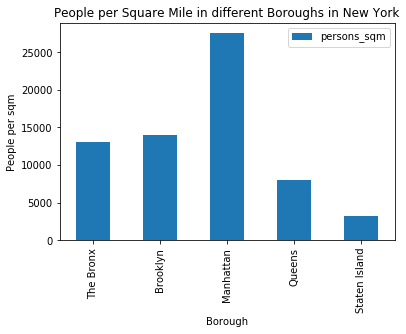

In [53]:
df.set_index('borough', inplace=True)
df = df.drop(columns=["county","population","gdp_per_capita"])
df.head()
df.plot(kind='bar')
plt.title('People per Square Mile in different Boroughs in New York')
plt.xlabel('Borough')
plt.ylabel('People per sqm')

We can see above that Manhattan has the highest population density, followed by Brooklyn, Bronx, Queens and Staten Island. This gives us an idea of where more people live and will help us with the decision for the restaurant location.

### Demographics in New York City

In [55]:
response_obj = requests.get('https://en.wikipedia.org/wiki/Demographics_of_New_York_City').text
soup = BeautifulSoup(response_obj,'lxml')
Population_Census_Table = soup.select_one('.wikitable:nth-of-type(5)') #use css selector to target correct table.

jurisdictions = []
rows = Population_Census_Table.select("tbody > tr")[3:8]
for row in rows:
    jurisdiction = {}
    tds = row.select('td')
    jurisdiction["jurisdiction"] = tds[0].text.strip()
    jurisdiction["population_census"] = tds[1].text.strip()
    jurisdiction["White"] = float(tds[2].text.strip().replace(",",""))
    jurisdiction["African_Amercian"] = float(tds[3].text.strip().replace(",",""))
    jurisdiction["Asian"] = float(tds[4].text.strip().replace(",",""))
    jurisdiction["Other"] = float(tds[5].text.strip().replace(",",""))
    jurisdiction["Mixed_Race"] = float(tds[6].text.strip().replace(",",""))
    jurisdiction["Hispanic_Latino_of_other_race"] = float(tds[7].text.strip().replace(",",""))
    jurisdictions.append(jurisdiction)

print(jurisdictions)

[{'jurisdiction': 'Queens', 'population_census': '2,229,379', 'White': 44.1, 'African_Amercian': 20.0, 'Asian': 17.6, 'Other': 12.3, 'Mixed_Race': 6.1, '%Hispanic_Latino_of_other_race': 25.0}, {'jurisdiction': 'Manhattan', 'population_census': '1,537,195', 'White': 54.4, 'African_Amercian': 17.4, 'Asian': 9.4, 'Other': 14.7, 'Mixed_Race': 4.1, '%Hispanic_Latino_of_other_race': 27.2}, {'jurisdiction': 'Bronx', 'population_census': '1,332,650', 'White': 29.9, 'African_Amercian': 35.6, 'Asian': 3.0, 'Other': 25.7, 'Mixed_Race': 5.8, '%Hispanic_Latino_of_other_race': 48.4}, {'jurisdiction': 'Staten Island', 'population_census': '443,728', 'White': 77.6, 'African_Amercian': 9.7, 'Asian': 5.7, 'Other': 4.3, 'Mixed_Race': 2.7, '%Hispanic_Latino_of_other_race': 12.1}, {'jurisdiction': 'NYC Total', 'population_census': '8,008,278', 'White': 44.7, 'African_Amercian': 26.6, 'Asian': 9.8, 'Other': 14.0, 'Mixed_Race': 4.9, '%Hispanic_Latino_of_other_race': 27.0}]


In [58]:
df = pd.DataFrame(jurisdictions, columns=["jurisdiction","population_census", "White", "African_Amercian", "Asian", "Other","Mixed_Race","Hispanic_Latino_of_other_race"])
df.head()

#All numbers below are in %

,jurisdiction,population_census,White,African_Amercian,Asian,Other,Mixed_Race,Hispanic_Latino_of_other_race
0,Queens,"2,229,379",44.1,20.0,17.6,12.3,6.1,NaN
1,Manhattan,"1,537,195",54.4,17.4,9.4,14.7,4.1,NaN
2,Bronx,"1,332,650",29.9,35.6,3.0,25.7,5.8,NaN
3,Staten Island,"443,728",77.6,9.7,5.7,4.3,2.7,NaN
4,NYC Total,"8,008,278",44.7,26.6,9.8,14.0,4.9,NaN


Our initial analysis shows that Queens is the fourth in population density. However, it has the highest Asian ethnic minority population - which is what we want to focus on for the purpose of opening an Indian restaurant.

Mantthan is the most populous urban area in New York City, and it has the second highest Asian ethnic minority population in NYC. We will keep this in mind for making a conclusion later in this study.

## Foursquare API

Now we use the Foursquare API to get the venues in different neighborhoods to find out which neighborhoods have the most Indian restaurants with their latitude & longitudes.

Below we define functions/methods that will help us accomplish this.

In [59]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'POMDLLVBQ3BDVRBS5WR1WZHQT0DLR0BZ04ZVZSMIEOVLWKXI'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='MV0ZPQIDKQFTENO3CBEP2G15QA5NZP3VVWZ5MG3JFGTO5BCE' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
        
    CLIENT_ID = 'POMDLLVBQ3BDVRBS5WR1WZHQT0DLR0BZ04ZVZSMIEOVLWKXI'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='MV0ZPQIDKQFTENO3CBEP2G15QA5NZP3VVWZ5MG3JFGTO5BCE' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [60]:
new_york_data=get_new_york_data()
new_york_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [61]:
new_york_data.shape

(306, 4)

This shows us that there are 306 Neighborhoods to choose from (based on this dataset).

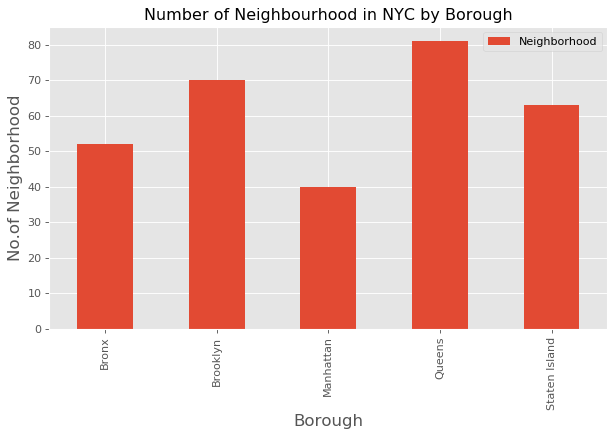

In [62]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

We can see that Queens has the highest number of neighborhoods (around 80) followed by Brooklyn, Staten Island, Bronc and Manhattan

In [63]:

# prepare neighborhood list that contains indian restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:1
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:0
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:1
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [64]:
indian_rest_ny.shape

(154, 4)

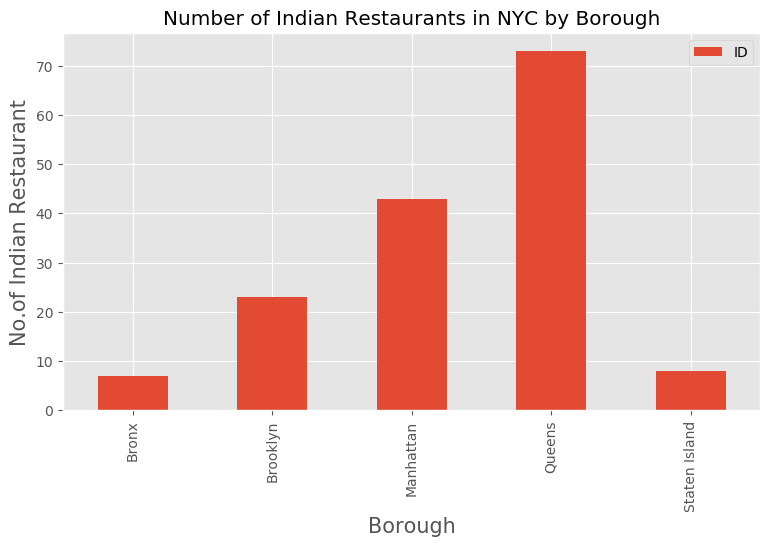

In [65]:

from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We can see that Queens has the most Indian restaurants in New York City followed by Manhattan. It can also be seen that Bronx and Staten Island have some of the least Indian restaurants.

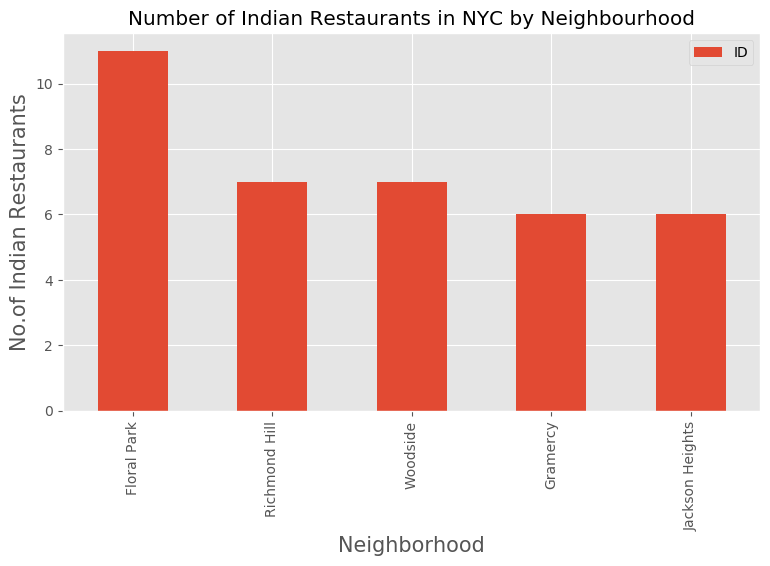

In [66]:

from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Floral Park, Queens has the highest indian restaurants out of all neighborhoods. 

Now we find average rating, likes and tips by Boroughs.

In [67]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.6    10
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 570c3a3fcd10eecd0d0434cd
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.8     9
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.1     4
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     37     8.5    25
                         ID          Name  Likes  Rating  Tips

No data available for id= 4babc24ef964a5200ac73ae3
No data available for id= 57d9e9a1498e545076560fef
No data available for id= 50a287a7e4b0033f830f06db
No data available for id= 5b931ea69d7468002c3b1382
No data available for id= 5b931ea69d7468002c3b1382
No data available for id= 50e1c9708aca7ff2b3e50353
No data available for id= 5625af69498ebbc62b61a382
No data available for id= 4ee8dddb5c5c99a2dc780825
No data available for id= 4f1f4996e4b01ff351a7a50c
No data available for id= 539a4ff0498e79c6745baba9
No data available for id= 539e27b0498e2eba582085ee
No data available for id= 4b787c49f964a5209cd12ee3
No data available for id= 4b9030abf964a520397b33e3
No data available for id= 4df0f39dd4c04d0392c853ea
No data available for id= 4c0e256ab1b676b06589e186
No data available for id= 4b96926df964a520abd534e3
No data available for id= 4be334312fc7d13a7a81083a
No data available for id= 4bad49a0f964a52041423be3
No data available for id= 4cc08b0900d83704ed474b5c
No data available for id= 4bad4

In [68]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.6,10
1,Bronx,Williamsbridge,0,0,0,0.0,0
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.1,4


In [69]:
indian_rest_stats_ny.shape


(154, 7)

In [71]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')
indian_rest_stats_ny_csv.shape


(154, 7)

In [72]:
indian_rest_stats_ny_csv.head()


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.6,10
1,Bronx,Williamsbridge,0,0,0,0.0,0
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.1,4


In [74]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       154 non-null    object 
 1   Neighborhood  154 non-null    object 
 2   ID            154 non-null    object 
 3   Name          154 non-null    object 
 4   Likes         154 non-null    float64
 5   Rating        154 non-null    float64
 6   Tips          154 non-null    float64
dtypes: float64(3), object(4)
memory usage: 6.1+ KB


In [75]:
# Restaurants with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                835
Rating                               8.7
Tips                                 257
Name: 38, dtype: object

In [76]:
# Restaurants with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]


Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                607
Rating                               9.1
Tips                                 153
Name: 42, dtype: object

In [77]:
# Restaurants with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                835
Rating                               8.7
Tips                                 257
Name: 38, dtype: object

In [78]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

We found neighborhoods with the highest ratings

In [81]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Neighborhood,Average Rating
69,Tribeca,9.10
52,Prospect Heights,9.00
31,Greenwich Village,9.00
74,West Village,8.85
20,East Village,8.70
26,Fort Greene,8.70
11,Chelsea,8.70
44,Midtown,8.70
13,Clinton Hill,8.70
53,Prospect Lefferts Gardens,8.70


We found neighborhoods with the highest ratings


In [82]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,6.156522
2,Manhattan,4.995349
0,Bronx,4.728571
3,Queens,0.000000
4,Staten Island,0.000000


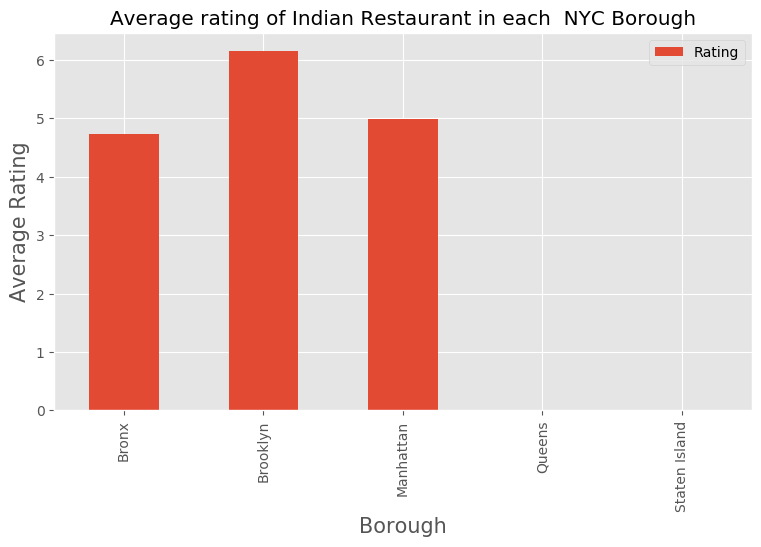

In [83]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Brooklyn has the highest rating Indian restaurants followed by Manhattan and then Bronx

In [85]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
10,Central Harlem,8.000000
11,Chelsea,8.700000
13,Clinton Hill,8.700000
18,East Flatbush,8.000000
20,East Village,8.700000
26,Fort Greene,8.700000
31,Greenwich Village,9.000000
44,Midtown,8.700000
45,Morningside Heights,8.100000
48,North Side,8.400000


In [86]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
15,Manhattan,Tribeca,40.721522,-74.010683,9.10
7,Manhattan,Greenwich Village,40.726933,-73.999914,9.00
11,Brooklyn,Prospect Heights,40.676822,-73.964859,9.00
17,Manhattan,West Village,40.734434,-74.006180,8.85
2,Staten Island,Chelsea,40.594726,-74.189560,8.70
3,Brooklyn,Clinton Hill,40.693229,-73.967843,8.70
5,Manhattan,East Village,40.727847,-73.982226,8.70
6,Brooklyn,Fort Greene,40.688527,-73.972906,8.70
8,Manhattan,Midtown,40.754691,-73.981669,8.70
1,Manhattan,Chelsea,40.744035,-74.003116,8.70


## Results & Discussion <a name="results"></a>

In [88]:
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)
ny_map

In [90]:

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

### Neighborhoods with highest ratings

In [91]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Our results and findings show that:

* Manhattan has the highest population density, followed by Brooklyn, Bronx, Queens and Staten Island.
* Queens is the fourth in population density. However, it has the highest Asian ethnic minority population
* Mantthan is the most populous urban area in New York City, and it has the second highest Asian ethnic minority population in NYC. 
* Queens has the most Indian restaurants in New York City followed by Manhattan. 
* Floral Park, Queens has the highest indian restaurants out of all neighborhoods.
* Tribeca Manhatam and Greenwich Village Manhattan have the best rating Indian restaurants and that Manhattan has the highest ratings restaurants followed by Brooklyn 

## Conclusion

From all our analysis and results & findings, we can come to a conclusion that Manhattan would be a great place to open an indian restaurant since it has the highest population density and has the 2nd highest Asian population which will attract a large crowd. It also has some of the highest rated Indian restaurants so people probably stay in that area when looking for Indian food. 

Another conclusion is that Queens can also be a good option if they want to be close to other Indian restaurants since it has the highest Asian population and it also has highest number of Indian restaurants.

This is a basic data science analysis. We can do further analysis using other algorithms in the future